#### RQ1: How does the logical consistency of the CBM change when introducing the requirements via Fuzzy Loss

- This RQ aims to evaluate the logical consistency of the CBM and validate the claim that the FuzzyLoss CBM learned the rules and adheres to them.
- Load the models
- Load the GTSRB Dataset
- Load the Raw Fuzzy Loss
- Calculate Fuzzy Loss on the test set. (GTSRB, BTS)
- Calculate Rule violations on the test set. (GTSRB, BTS)
- Calculate the HD on the test set (GTSRB, BTS)
- Calculate CL-Matrix

In [1]:
import sys
from pathlib import Path

current_dir = Path.cwd()
parent_dir = current_dir.parent
sys.path.insert(0, str(f"{parent_dir}/src"))

from models.architectures import CBMSequentialEfficientNetFCN
from train_cbm import cbm_load_config

In [2]:
baseline_cbm_config = cbm_load_config(Path("../files/configs/GTSRB_CBM_config_loading.yaml"))
baseline_cbm = CBMSequentialEfficientNetFCN(baseline_cbm_config)
fuzzy_cbm_config = cbm_load_config(Path("../files/configs/GTSRB_CBM_config_best_trial_loading.yaml"))
fuzzy_cbm = CBMSequentialEfficientNetFCN(fuzzy_cbm_config)

Directory 'experiments/20251002_161945' created successfully.
Directory 'experiments/20251002_161945' created successfully.


In [3]:
# loading the concrete models
baseline_cbm_concept_predictor_path = Path("../experiments/baseline_cbm/models/20251001_083717_concept_predictor_best_model.pt")
baseline_cbm_label_predictor_path = Path("../experiments/baseline_cbm/models/20251001_083717_label_predictor_best_model.pt")
fuzzy_cbm_concept_predictor_path = Path("../experiments/fuzzy_CBM/models/20251001_113637_concept_predictor_best_model.pt")
fuzzy_cbm_label_precitor_path = Path("../experiments/fuzzy_CBM/models/20251001_113637_label_predictor_best_model.pt")

In [4]:
import torch

# Load the baseline model components
baseline_cbm.concept_predictor.load_state_dict(
    torch.load(baseline_cbm_concept_predictor_path, map_location=baseline_cbm_config.device, weights_only=True)
)
baseline_cbm.label_predictor.load_state_dict(
    torch.load(baseline_cbm_label_predictor_path, map_location=baseline_cbm_config.device, weights_only=True)
)

# Load the fuzzy model components
fuzzy_cbm.concept_predictor.load_state_dict(
    torch.load(fuzzy_cbm_concept_predictor_path, map_location=fuzzy_cbm_config.device, weights_only=True)
)
fuzzy_cbm.label_predictor.load_state_dict(
    torch.load(fuzzy_cbm_label_precitor_path, map_location=fuzzy_cbm_config.device, weights_only=True)
)

# Set models to evaluation mode
baseline_cbm.eval()
fuzzy_cbm.eval()

print("Model components loaded successfully!")
print(f"Baseline CBM loaded from {baseline_cbm_concept_predictor_path.parent}")
print(f"Fuzzy CBM loaded from {fuzzy_cbm_concept_predictor_path.parent}")

Model components loaded successfully!
Baseline CBM loaded from ../experiments/baseline_cbm/models
Fuzzy CBM loaded from ../experiments/fuzzy_CBM/models


In [5]:
dataset_factory = baseline_cbm_config.dataset.factory(
    seed=baseline_cbm_config.seed, config=baseline_cbm_config.dataset
).set_dataloaders()
train_loader = dataset_factory.train_dataloader
val_loader = dataset_factory.val_dataloader
test_loader = dataset_factory.test_dataloader

In [ ]:
# calculating the accuracy on the test of the model
from models.trainer.cbm_trainer import CBMTrainer
baseline_cbm_trainer = CBMTrainer(
    config=baseline_cbm_config,
    model=baseline_cbm,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
)
avg_loss_baseline, acc_baseline = baseline_cbm_trainer.concept_predictor_trainer.test(dataloader=test_loader, mode="test")
fuzzycbm_trainer = CBMTrainer(
    config=fuzzy_cbm_config,
    model=fuzzy_cbm,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
)
avg_loss_fuzzy, acc_fuzzy = fuzzycbm_trainer.concept_predictor_trainer.test(dataloader=test_loader, mode="test")

Val [98/99] | Loss 0.0075019598 : 100%|██████████| 99/99 [00:33<00:00,  2.93it/s]
Val [98/99] | Loss 0.4575287998 : 100%|██████████| 99/99 [00:38<00:00,  2.55it/s]


Baseline CBM - Test Loss: 0.0095, Test Accuracy: 0.9975
Fuzzy CBM - Test Loss: 0.4617, Test Accuracy: 0.9979


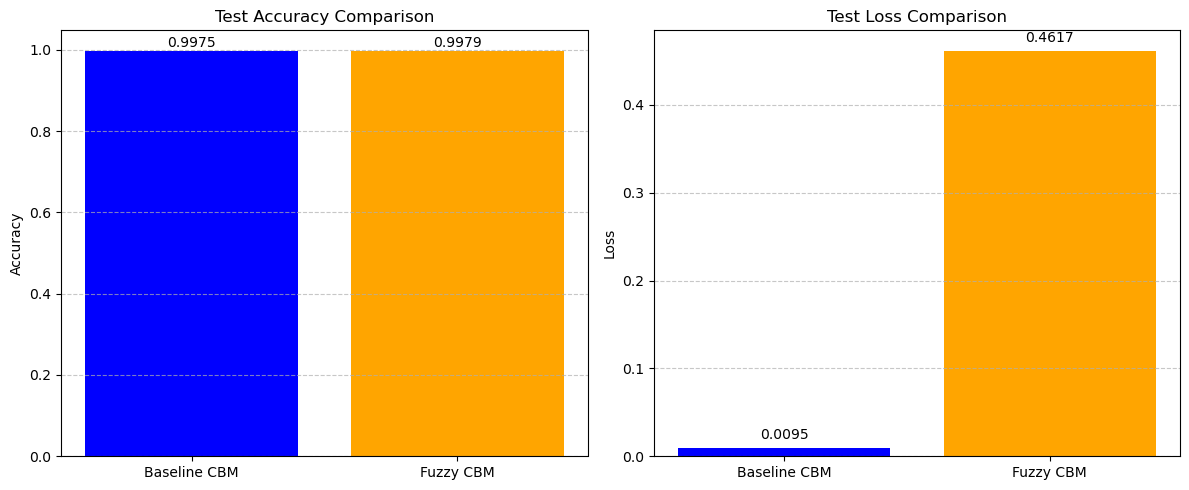

In [12]:
import numpy as np

print(f"Baseline CBM - Test Loss: {avg_loss_baseline:.4f}, Test Accuracy: {acc_baseline:.4f}")
print(f"Fuzzy CBM - Test Loss: {avg_loss_fuzzy:.4f}, Test Accuracy: {acc_fuzzy:.4f}")

# Create a comparison bar chart
import matplotlib.pyplot as plt

models = ['Baseline CBM', 'Fuzzy CBM']
accuracies = [acc_baseline, acc_fuzzy]
losses = [avg_loss_baseline, avg_loss_fuzzy]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax[0].bar(models, accuracies, color=['blue', 'orange'])
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Test Accuracy Comparison')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(accuracies):
    ax[0].text(i, v+0.01, f'{v:.4f}', ha='center')

# Loss plot
ax[1].bar(models, losses, color=['blue', 'orange'])
ax[1].set_ylabel('Loss')
ax[1].set_title('Test Loss Comparison')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(losses):
    ax[1].text(i, v+0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()